In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from src.graph import NeighborsGraph
from tqdm import tqdm

In [2]:
graph = NeighborsGraph.load('../data/dataset/dataset_graph.pkl')

def add_graph_info(results_df:pd.DataFrame, graph:NeighborsGraph):

    graph_info_df = list()
    for id_ in tqdm(results_df.index, 'add_graph_info'):
        neighbor_distances = graph.get_neighbor_distances(id_)
        graph_info = dict()
        graph_info['mean_distance_to_neighbors'] = np.mean(neighbor_distances)
        graph_info['distance_to_nearest_neighbor'] = np.min(neighbor_distances)
        graph_info['distance_to_farthest_neighbor'] = np.max(neighbor_distances)
        graph_info['neighbor_ids'] = ','.join(graph.get_neighbor_ids(id_))
        graph_info_df.append(graph_info)
    graph_info_df = pd.DataFrame(graph_info_df, index=results_df.index)
    results_df = results_df.merge(graph_info_df, right_index=True, left_index=True)
    return results_df

In [3]:
model_name = 'model_v2'

annotated_results_df = pd.read_csv('../data/results/dataset_false_negative_annotated.csv', index_col=0)

mislabeled_ids = annotated_results_df[annotated_results_df.category.str.contains('error')].index

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0).assign(dataset='train')
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0).assign(dataset='test')

results_df = pd.concat([train_results_df, test_results_df])
results_df = results_df.rename(columns={f'{model_name}_output_0':'model_output_0', f'{model_name}_output_1':'model_output_1', f'{model_name}_label':'model_label'})[['model_label', 'model_output_0', 'model_output_1', 'dataset']].copy()
results_df = results_df.merge(pd.read_csv('../data/dataset/dataset.csv', index_col=0), left_index=True, right_index=True)
results_df['category'] = results_df.index.map(annotated_results_df.category).fillna('none')
results_df = add_graph_info(results_df, graph)

add_graph_info: 100%|██████████| 276590/276590 [01:04<00:00, 4316.04it/s]


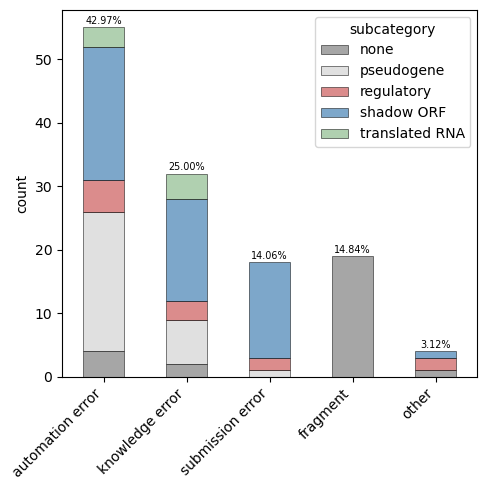

In [4]:
def figure(results_df:pd.DataFrame, threshold:float=0.95):

    results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)
    results_df = results_df[(results_df.model_label == 0) & (results_df.label == 1)].copy() # Get all false positives. 
    results_df = results_df[results_df.category.str.contains('error') | results_df.category.str.contains('fragment')]

    n = len(results_df)

    fig, ax = plt.subplots(figsize=(5, 5))

    ax_df = pd.DataFrame(index=results_df.index)

    categories = ['automation error','knowledge error',  'submission error', 'fragment', 'other']
    subcategories = ['pseudogene', 'shadow ORF', 'regulatory', 'translated RNA', 'none']

    palette = {'pseudogene':'lightgray', 'shadow ORF':'steelblue', 'regulatory':'indianred', 'translated RNA':'darkseagreen', 'none':'gray'}
    ax_df['category'] = np.select([results_df.category.str.contains(category) for category in categories], categories, default='other')
    ax_df['subcategory'] = np.select([results_df.category.str.contains(category) for category in subcategories], subcategories, default='none')
    ax_df['count'] = 1
    ax_df = ax_df.pivot_table(index='category', columns='subcategory', values='count', aggfunc='sum', fill_value=0).loc[categories]
    ax_df.plot(kind='bar', stacked=True, color=palette, edgecolor='black', lw=0.5, ax=ax, alpha=0.7)
    ax.set_xticks(np.arange(len(categories)), labels=categories, ha='right', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('count')

    heights = ax_df.sum(axis=1)
    for x, y in zip(np.arange(len(categories)), heights):
        ax.text(x, y + 0.5, f'{100 * y / n:.2f}%', ha='center', fontsize='x-small')

    fig.tight_layout()
    plt.show()

figure(results_df)



In [5]:
# Want to focus on the sequences which don't have a very nearby neighbor in embedding space, as it won't be productive 
# to look at sequences with very close homologs. 

def count_neighbors(neighbor_ids, label:int=0):
    neighbor_ids = neighbor_ids.split(',')
    return (results_df.loc[neighbor_ids].label == label).sum()

def table(results_df:pd.DataFrame, min_distance_to_nearest_neighbor:float=30):
    df = results_df[results_df.distance_to_nearest_neighbor > min_distance_to_nearest_neighbor].copy()
    # df.loc[np.intersect1d(mislabeled_ids, df.index), 'label'] = 0
    df['n_neighbors_spurious'] = df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=0))
    df['n_neighbors_real'] = df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=1))
    df['n_neighbors_same_label']= [row.n_neighbors_spurious if (row.label == 0) else row.n_neighbors_real for row in df.itertuples()]
    df['length'] = df.seq.apply(len)
    n_total, n_real, n_spurious = len(df), (df.label == 1).sum(), (df.label == 0).sum()

    table_df = pd.DataFrame(index=['real', 'spurious', 'total'])
    for n in range(1, 6):
        df_ = df[df.n_neighbors_same_label < n]
        table_df[f'< {n}'] = [f'{(100 * (df_.label == 1).sum() / n_real):.2f}%', f'{(100 * (df_.label == 0).sum() / n_spurious):.2f}%', f'{100 * len(df_) / n_total:.2f}%']
    table_df['total'] = [n_real, n_spurious, n_total]
    return table_df, df[(df.label == 1) & (df.n_neighbors_spurious > 3)].index

table_df, suspect_ids = table(results_df)
table_df

,< 1,< 2,< 3,< 4,< 5,total
real,2.46%,4.01%,5.61%,7.11%,11.87%,1870
spurious,2.52%,4.03%,7.06%,10.92%,27.56%,595
total,2.47%,4.02%,5.96%,8.03%,15.66%,2465


44.02676356018777


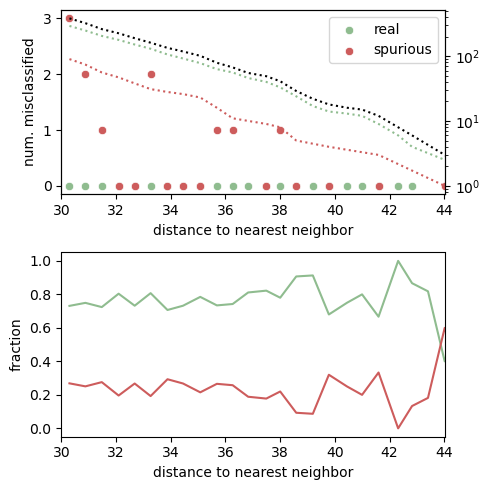

In [6]:
def figure(results_df, min_distance_to_nearest_neighbor:float=30, max_distance_to_nearest_neighbor:float=45, threshold:float=0.95):

    
    # results_df = results_df[results_df.dataset == 'test'].copy()
    results_df = results_df[results_df.distance_to_nearest_neighbor > min_distance_to_nearest_neighbor].copy()
    results_df = results_df[results_df.distance_to_nearest_neighbor < max_distance_to_nearest_neighbor].copy()
    bin_labels, bin_edges = pd.cut(results_df.distance_to_nearest_neighbor, 25, retbins=True, labels=False)
    
    x_min = min_distance_to_nearest_neighbor
    x_max = results_df[(results_df.dataset == 'test') & (results_df.label == 0)].distance_to_nearest_neighbor.max()
    print(x_max)
    
    ax_df = pd.DataFrame(index=results_df.index)
    ax_df['dataset'] = results_df.dataset
    ax_df['bin_label'] = bin_labels
    ax_df['distance_to_nearest_neighbor'] = results_df.distance_to_nearest_neighbor
    ax_df['bin_value'] = ax_df.bin_label.map(ax_df.groupby('bin_label').distance_to_nearest_neighbor.mean())
    ax_df['model_label'] = np.where(results_df.model_output_0 > threshold, 'spurious', 'real')
    ax_df['label'] = ['real' if (label == 1) else 'spurious' for label in results_df.label]
    ax_df['correct'] = ax_df.label == ax_df.model_label
    ax_df['incorrect'] = ax_df.label != ax_df.model_label
    ax_df['is_spurious'] = ax_df.label == 'spurious'
    ax_df['is_real'] = ax_df.label == 'real'

    fig, (ax_a, ax_b) = plt.subplots(nrows=2, figsize=(5, 5), sharex=False)
    ax_a_ = ax_a.twinx()

    palette = {'spurious':'indianred', 'real':'darkseagreen'}

    # sns.lineplot(ax=ax_a, data=ax_df[ax_df.dataset == 'test'], x='bin_label', y='correct', hue='label', palette=palette, errorbar=None)
    for label, df in ax_df[ax_df.dataset == 'test'].groupby('label'):
        x = df.groupby('bin_label').bin_value.first()
        n = df.groupby('bin_label').apply(len, include_groups=False)
        y = df.groupby('bin_label').incorrect.sum()
        sns.scatterplot(ax=ax_a, x=x.values.ravel(), y=y.values.ravel(), color=palette[label], label=label)

    x = ax_df[ax_df.dataset == 'test'].groupby('bin_label').bin_value.first().values.ravel()
    y = [(ax_df[ax_df.dataset == 'test'].distance_to_nearest_neighbor > x_).sum() for x_ in x]
    sns.lineplot(ax=ax_a_, x=x, y=y, color='black', ls=':')

    for label, df in ax_df[ax_df.dataset == 'test'].groupby('label'):
        x = df.groupby('bin_label').bin_value.first().values.ravel()
        y = [(df.distance_to_nearest_neighbor > x_).sum() for x_ in x]
        sns.lineplot(ax=ax_a_, x=x, y=y, color=palette[label], ls=':')
    # ax_a_.set_ylim()
    # ax_a.set_ylim(ymax=10, ymin=0)
    ax_a_.set_yscale('log')

    ax_a.set_xlim(xmax=x_max, xmin=x_min)
    ax_a.set_ylabel('num. misclassified')
    ax_a_.set_ylabel('')
    ax_a.set_xlabel('distance to nearest neighbor')

    # sns.histplot(ax=ax_b, data=ax_df[ax_df.dataset == 'test'], hue='label', multiple='dodge', bins=bin_edges, palette=palette, x='distance_to_nearest_neighbor')
    # ax_b.set_xlim(xmax=x_max, xmin=x_min)

    # ax_b_ = ax_b.twinx()
    # x = ax_df[ax_df.dataset == 'test'].groupby('bin_label').bin_value.first().values.ravel()
    # y = [(ax_df[ax_df.dataset == 'test'].bin_value > x_).sum() for x_ in x]
    # sns.lineplot(ax=ax_b_, x=x, y=y, color='black', ls=':')

    # for label, df in ax_df[ax_df.dataset == 'test'].groupby('label'):
    #     x = df.groupby('bin_label').bin_value.first().values.ravel()
    #     y = [(df.bin_value > x_).sum() for x_ in x]
    #     sns.lineplot(ax=ax_b_, x=x, y=y, color=palette[label], ls=':', label=label)
    # ax_b_.set_ylim(ymax=100, ymin=0)
    # ax_b.set_yscale('log')

    sns.lineplot(ax=ax_b, data=ax_df, x='bin_value', y='is_real', color='darkseagreen', errorbar=None)
    sns.lineplot(ax=ax_b, data=ax_df, x='bin_value', y='is_spurious', color='indianred', errorbar=None)

    ax_b.set_ylabel('fraction')
    ax_b.set_xlabel('distance to nearest neighbor')
    ax_b.set_xlim(xmax=x_max, xmin=x_min)
    
    fig.tight_layout()
    plt.show()

figure(results_df)



In [31]:
results_df['n_unknown'] = results_df.seq.str.count('X')

print('Maximum number of unknown amino acids in a real sequence:', results_df[results_df.label == 1].n_unknown.max())
print('Maximum number of unknown amino acids in a spurious sequence:', results_df[results_df.label == 0].n_unknown.max(), end='\n\n')

print('Mean number of unknown amino acids in a real sequence:', results_df[results_df.label == 1].n_unknown.mean())
print('Mean number of unknown amino acids in a spurious sequence:', results_df[results_df.label == 0].n_unknown.mean(), end='\n\n')

print('Fraction of real sequences with no unknown amino acids:', ((results_df.label == 1) & (results_df.n_unknown == 0)).sum() / (results_df.label == 1).sum())
print('Fraction of spurious sequences with no unknown amino acids:', ((results_df.label == 0) & (results_df.n_unknown == 0)).sum() / (results_df.label == 0).sum())

Maximum number of unknown amino acids in a real sequence: 19
Maximum number of unknown amino acids in a spurious sequence: 235

Mean number of unknown amino acids in a real sequence: 0.00284539993676889
Mean number of unknown amino acids in a spurious sequence: 0.09800278680910357

Fraction of real sequences with no unknown amino acids: 0.9983112667041941
Fraction of spurious sequences with no unknown amino acids: 0.9884463539247561


In [35]:
threshold = 0.95
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)
results_df['is_false_negative'] = (results_df.model_label == 0) & (results_df.label == 1)

print(f'Number of false spurious (threshold={threshold}) with an unknown amino acid:', ((results_df.is_false_negative) & (results_df.n_unknown > 0)).sum())
print(f'Fraction of false spurious (threshold={threshold}) with an unknown amino acid:', ((results_df.is_false_negative) & (results_df.n_unknown > 0)).sum() / results_df.is_false_negative.sum())

Number of false spurious (threshold=0.95) with an unknown amino acid: 1
Fraction of false spurious (threshold=0.95) with an unknown amino acid: 0.0033333333333333335


In [40]:
def table(results_df:pd.DataFrame, min_distance_to_nearest_neighbor:float=25):

    n_unknown = np.arange(20)
    results_df = results_df[(results_df.label == 1) & (results_df.distance_to_nearest_neighbor > min_distance_to_nearest_neighbor)].copy()
    results_df['n_unknown'] = results_df.seq.str.count('X')
    results_df['n_spurious_neighbors'] = results_df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=0))
    results_df['has_spurious_neighbor'] = results_df.n_spurious_neighbors > 0
    results_df = results_df[results_df.n_unknown.isin(n_unknown)].copy()

    table_df = pd.DataFrame(index=n_unknown)
    table_df['n_unknown'] = n_unknown
    table_df['total'] = results_df.groupby('n_unknown').apply(len, include_groups=False)
    table_df['total_with_spurious_neighbor'] = results_df.groupby('n_unknown').has_spurious_neighbor.sum()
    table_df['percent_with_spurious_neighbor'] = 100 * table_df.total_with_spurious_neighbor / table_df.total 
    table_df = table_df.fillna(0)
    table_df['percent_with_spurious_neighbor'] = [f'{p:.1f}%' for p in table_df.percent_with_spurious_neighbor]
    table_df = table_df.set_index('n_unknown')
    return table_df.T


In [41]:
table_df = table(results_df, min_distance_to_nearest_neighbor=0)
table_df


n_unknown,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
total,258928.0,303.0,73.0,32.0,12.0,3.0,3.0,5.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
total_with_spurious_neighbor,1190.0,15.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percent_with_spurious_neighbor,0.5%,5.0%,8.2%,3.1%,8.3%,0.0%,33.3%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


In [37]:

# def figure(results_df:pd.DataFrame, min_distance_to_nearest_neighbor:float=25): # , threshold:float=0.5):

#     n_unknown = np.arange(7)

#     results_df = results_df[(results_df.label == 1) & (results_df.distance_to_nearest_neighbor > min_distance_to_nearest_neighbor)].copy()
#     results_df['n_unknown'] = results_df.seq.str.count('X')
#     results_df = results_df[results_df.n_unknown.isin(n_unknown)].copy()
#     results_df['n_spurious_neighbors'] = results_df.neighbor_ids.apply(lambda ids : count_neighbors(ids, label=0))

#     fig, ax = plt.subplots(figsize=(5, 5))

#     # ax_df = pd.DataFrame(index=['spurious', 'real'], columns=np.arange(0, 10))
#     ax_df = list()
#     for n in range(3):
#         ax_df_ = pd.DataFrame(index=n_unknown)
#         ax_df_['n_unknown'] = ax_df_.index
#         ax_df_['n_spurious_neighbors'] = n
#         ax_df_['count'] = ax_df_.n_unknown.map(results_df.groupby('n_unknown').apply(lambda df_ : (df_.n_spurious_neighbors > n).sum(), include_groups=False))
#         ax_df_['total'] = ax_df_.n_unknown.map(results_df.groupby('n_unknown').apply(len, include_groups=False))
#         ax_df_['percent'] = [f'{p:.1f}%' for p in 100 * ax_df_['count'] / ax_df_['total']]
#         ax_df.append(ax_df_)
#     ax_df = pd.concat(ax_df)

#     palette = {0:'darkseagreen', 1:'steelblue', 2:'indianred'}
#     sns.barplot(ax=ax, data=ax_df, hue='n_spurious_neighbors', y='count', x='n_unknown', lw=0.5, edgecolor='black', palette=palette)

#     ax.set_xlabel('num. X tokens in sequence')
#     ax.set_ylabel('num. with >n spurious neighbors')
#     ax.set_yscale('log')
#     plt.show()
